In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np


In [2]:
#!pip install astropy


In [3]:
from astropy.table import Table
import requests
import time
from io import StringIO

In [4]:
ps1filename = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
fitscut = "https://ps1images.stsci.edu/cgi-bin/fitscut.cgi"
 
def getimages(tra, tdec, size=240, filters="grizy", format="fits", imagetypes="stack"):
     
    """Query ps1filenames.py service for multiple positions to get a list of images
    This adds a url column to the table to retrieve the cutout.
     
    tra, tdec = list of positions in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    format = data format (options are "fits", "jpg", or "png")
    imagetypes = list of any of the acceptable image types.  Default is stack;
        other common choices include warp (single-epoch images), stack.wt (weight image),
        stack.mask, stack.exp (exposure time), stack.num (number of exposures),
        warp.wt, and warp.mask.  This parameter can be a list of strings or a
        comma-separated string.
 
    Returns an astropy table with the results
    """
     
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    # if imagetypes is a list, convert to a comma-separated string
    if not isinstance(imagetypes,str):
        imagetypes = ",".join(imagetypes)
    # put the positions in an in-memory file object
    cbuf = StringIO()
    cbuf.write('\n'.join(["{} {}".format(ra, dec) for (ra, dec) in zip(tra,tdec)]))
    cbuf.seek(0)
    # use requests.post to pass in positions as a file
    r = requests.post(ps1filename, data=dict(filters=filters, type=imagetypes),
        files=dict(file=cbuf))
    r.raise_for_status()
    tab = Table.read(r.text, format="ascii")
 
    urlbase = "{}?size={}&format={}".format(fitscut,size,format)
    tab["url"] = ["{}&ra={}&dec={}&red={}".format(urlbase,ra,dec,filename)
            for (filename,ra,dec) in zip(tab["filename"],tab["ra"],tab["dec"])]
    return tab
 
 
if __name__ == "__main__":
    t0 = time.time()
 
    # create a test set of image positions
    tdec = np.append(np.arange(31)*3.95 - 29.1, 88.0)
    tra = np.append(np.arange(31)*12., 0.0)
 
    # get the PS1 info for those positions
    table = getimages(tra,tdec,filters="ri")
    print("{:.1f} s: got list of {} images for {} positions".format(time.time()-t0,len(table),len(tra)))
 
    # extract cutout for each position/filter combination
    for row in table:
        ra = row['ra']
        dec = row['dec']
        projcell = row['projcell']
        subcell = row['subcell']
        filter = row['filter']
 
        # create a name for the image -- could also include the projection cell or other info
        fname = "t{:08.4f}{:+07.4f}.{}.fits".format(ra,dec,filter)
 
        url = row["url"]
        print("%11.6f %10.6f skycell.%4.4d.%3.3d %s" % (ra, dec, projcell, subcell, fname))
        r = requests.get(url)
        open(fname,"wb").write(r.content)
    print("{:.1f} s: retrieved {} FITS files for {} positions".format(time.time()-t0,len(table),len(tra)))

1.6 s: got list of 64 images for 32 positions
   0.000000 -29.100000 skycell.0635.074 t000.0000-29.1000.i.fits
   0.000000 -29.100000 skycell.0635.074 t000.0000-29.1000.r.fits
  12.000000 -25.150000 skycell.0717.077 t012.0000-25.1500.i.fits
  12.000000 -25.150000 skycell.0717.077 t012.0000-25.1500.r.fits
  24.000000 -21.200000 skycell.0802.068 t024.0000-21.2000.i.fits
  24.000000 -21.200000 skycell.0802.068 t024.0000-21.2000.r.fits
  36.000000 -17.250000 skycell.0889.068 t036.0000-17.2500.i.fits
  36.000000 -17.250000 skycell.0889.068 t036.0000-17.2500.r.fits
  48.000000 -13.300000 skycell.0978.067 t048.0000-13.3000.i.fits
  48.000000 -13.300000 skycell.0978.067 t048.0000-13.3000.r.fits
  60.000000  -9.350000 skycell.1069.066 t060.0000-9.3500.i.fits
  60.000000  -9.350000 skycell.1069.066 t060.0000-9.3500.r.fits
  72.000000  -5.400000 skycell.1161.066 t072.0000-5.4000.i.fits
  72.000000  -5.400000 skycell.1161.066 t072.0000-5.4000.r.fits
  84.000000  -1.450000 skycell.1253.064 t084.000

In [5]:
%matplotlib inline
from astropy.io import ascii
from astropy.table import Table

import sys
import re
import numpy as np
import pylab
import json
import requests

try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try: # Python 3.x
    import http.client as httplib 
except ImportError:  # Python 2.x
    import httplib  

In [7]:
def ps1cone(ra,dec,radius,table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a cone search of the PS1 catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return ps1search(table=table,release=release,format=format,columns=columns,
                    baseurl=baseurl, verbose=verbose, **data)


def ps1search(table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a general search of the PS1 catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    checklegal(table,release)
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = "{baseurl}/{release}/{table}.{format}".format(**locals())
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in ps1metadata(table,release)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

# either get or post works
#    r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def checklegal(table,release):
    """Checks if this combination of table and release is acceptable
    
    Raises a VelueError exception if there is problem
    """
    
    releaselist = ("dr1", "dr2")
    if release not in ("dr1","dr2"):
        raise ValueError("Bad value for release (must be one of {})".format(', '.join(releaselist)))
    if release=="dr1":
        tablelist = ("mean", "stack")
    else:
        tablelist = ("mean", "stack", "detection")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(release, ", ".join(tablelist)))


def ps1metadata(table="mean",release="dr1",
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs"):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    
    checklegal(table,release)
    url = "{baseurl}/{release}/{table}/metadata".format(**locals())
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def mastQuery(request):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object

    Returns head,content where head is the response HTTP headers, and content is the returned data
    """
    
    server='mast.stsci.edu'

    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    requestString = json.dumps(request)
    requestString = urlencode(requestString)
    
    # opening the https connection
    conn = httplib.HTTPSConnection(server)

    # Making the query
    conn.request("POST", "/api/v0/invoke", "request="+requestString, headers)

    # Getting the response
    resp = conn.getresponse()
    head = resp.getheaders()
    content = resp.read().decode('utf-8')

    # Close the https connection
    conn.close()

    return head,content


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    headers,resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [8]:
meta = ps1metadata("mean","dr2")
meta

name,type,description
str17,str12,str142
objName,char,IAU name for this object.
objAltName1,char,Alternate name for this object.
objAltName2,char,Altername name for this object.
objAltName3,char,Altername name for this object.
objID,long,Unique object identifier.
uniquePspsOBid,long,Unique internal PSPS object identifier.
ippObjID,long,IPP internal object identifier.
surveyID,unsignedByte,Survey identifier. Details in the Survey table.
htmID,long,Hierarchical triangular mesh (Szalay 2007) index.


Search an area of sky by right ascention and declination

In [9]:
ra = 187.706
dec = 12.391
radius = 50.0/3600.0
constraints = {'nDetections.gt':1}

# strip blanks and weed out blank and commented-out values
columns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
    gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag""".split(',')
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]
results = ps1cone(ra,dec,radius,release='dr2',columns=columns,verbose=True,**constraints)
# print first few lines
lines = results.split('\n')
print(len(lines),"rows in results -- first 5 rows:")
print('\n'.join(lines[:6]))

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.csv?nDetections.gt=1&ra=187.706&dec=12.391&radius=0.013888888888888888&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CgMeanPSFMag%2CrMeanPSFMag%2CiMeanPSFMag%2CzMeanPSFMag%2CyMeanPSFMag%5D
47 rows in results -- first 5 rows:
objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
122851876947049923,187.69476386968975,12.382817851331282,8,2,1,2,3,0,19.867399215698242,18.59269905090332,19.06920051574707,18.139400482177734,-999.0
122851877008084336,187.70079849589698,12.378285588066493,15,3,2,5,5,0,21.162900924682617,-999.0,18.75429916381836,18.438899993896484,-999.0
122851877018527082,187.70183256713327,12.380539342373664,5,2,2,1,0,0,20.314599990844727,-999.0,18.168699264526367,-999.0,-999.0
122851877049294726,187.70494206905568,12.378523957309678,7,2,2,2,1,0,19.03059959411621,18.453699111938477,18.576099395751953,-999.0,-999.0
122851877062673559,1

Convert to astropy

In [10]:
tab = ascii.read(results)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    try:
        tab[col].format = ".4f"
        tab[col][tab[col] == -999.0] = np.nan
    except KeyError:
        print("{} not found".format(col))
tab

objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
122851876947049923,187.69476386968975,12.382817851331282,8,2,1,2,3,0,19.8674,18.5927,19.0692,18.1394,nan
122851877008084336,187.70079849589698,12.378285588066493,15,3,2,5,5,0,21.1629,nan,18.7543,18.4389,nan
122851877018527082,187.70183256713327,12.380539342373664,5,2,2,1,0,0,20.3146,nan,18.1687,nan,nan
122851877049294726,187.70494206905568,12.378523957309678,7,2,2,2,1,0,19.0306,18.4537,18.5761,nan,nan
122851877062673559,187.70625306033213,12.377545233303906,7,1,2,3,0,1,20.5210,18.9063,18.9627,nan,18.1421
122851877090477761,187.70901150138516,12.381089288872962,29,6,7,11,5,0,19.7468,17.7461,17.4915,17.6221,nan
122851877096718451,187.70969564,12.38158628,2,1,0,1,0,0,20.5734,nan,nan,nan,nan
122851877109888891,187.71098809,12.38200012,2,0,0,2,0,0,nan,nan,nan,nan,nan
122851877115528846,187.71134341,12.38181909,2,1,1,0,0,0,23.3524,17.3302,nan,nan,nan


Query single object by ojject id

In [11]:
results1 = ps1search(release='dr2',columns=columns,verbose=True,objid=122851876947049923)
tab1 = ascii.read(results1)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    try:
        tab1[col].format = ".4f"
        tab1[col][tab1[col] == -999.0] = np.nan
    except KeyError:
        print("{} not found".format(col))
tab1

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.csv?objid=122851876947049923&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CgMeanPSFMag%2CrMeanPSFMag%2CiMeanPSFMag%2CzMeanPSFMag%2CyMeanPSFMag%5D


objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
122851876947049923,187.69476386968975,12.382817851331282,8,2,1,2,3,0,19.8674,18.5927,19.0692,18.1394,nan


Search stack objects at same position

In [12]:
sconstraints = {'primaryDetection':1}

scolumns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
    nStackDetections,primaryDetection,
    gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag""".split(',')
# strip blanks and weed out blank and commented-out values
scolumns = [x.strip() for x in scolumns]
scolumns = [x for x in scolumns if x and not x.startswith('#')]

sresults = ps1cone(ra,dec,radius,table="stack",release="dr2",columns=scolumns,verbose=True,**sconstraints)
stab = ascii.read(sresults)
for col in scolumns:
    try:
        stab[col]
    except KeyError:
        print(col,"not found")
# improve the format
for filter in 'grizy':
    col = filter+'PSFMag'
    try:
        stab[col].format = ".4f"
        stab[col][stab[col] == -999.0] = np.nan
    except KeyError:
        print("{} not found".format(col))
stab


https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/stack.csv?primaryDetection=1&ra=187.706&dec=12.391&radius=0.013888888888888888&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CnStackDetections%2CprimaryDetection%2CgPSFMag%2CrPSFMag%2CiPSFMag%2CzPSFMag%2CyPSFMag%5D


objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,nStackDetections,primaryDetection,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
122851876947049923,187.69476028,12.382815,8,2,1,2,3,0,8,1,19.6062,18.6094,18.6439,18.5461,nan
122851877008084336,187.70080125,12.37828064,15,3,2,5,5,0,3,1,19.5519,nan,18.4844,18.4317,nan
122851877049294726,187.70495239,12.37851452,7,2,2,2,1,0,1,1,nan,18.2340,nan,nan,nan
122851877062673559,187.70624956,12.37754834,7,1,2,3,0,1,1,1,21.2941,nan,nan,18.3366,nan
122851877090477761,187.70902824,12.38101615,29,6,7,11,5,0,8,1,18.8032,nan,17.7515,17.7051,17.2640
122851877096718451,187.70969564,12.38158628,2,1,0,1,0,0,2,1,18.8283,nan,nan,nan,nan
122851877124637737,187.71246077,12.38100609,50,9,10,15,9,7,10,1,19.1700,18.0277,17.9962,17.8764,17.4738
122861876929948166,187.69304884,12.38978617,7,2,0,3,2,0,8,1,19.4459,18.5033,18.4054,18.3286,nan
122861876979515942,187.69789315,12.38779688,44,8,7,13,8,8,10,1,18.4712,17.4164,17.3963,17.3396,16.9031


Explore the tables

In [13]:
from astropy.table import join
jtab = join(stab,tab,join_type='outer')
jtab.sort('objID')
jtab_both = jtab[(jtab['primaryDetection']==1) & (jtab['nDetections']>1)]

#jtab[jtab['nStackDetections'].mask].show_in_notebook()
#jtab[~jtab['nStackDetections'].mask].show_in_notebook()
#jtab.show_in_notebook()
jtab_both.show_in_notebook()

idx,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,nStackDetections,primaryDetection,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
0,122851876947049923,187.69476028,12.382815,8,2,1,2,3,0,8,1,19.6062,18.6094,18.6439,18.5461,nan,--,--,--,--,--
1,122851877008084336,187.70080125,12.37828064,15,3,2,5,5,0,3,1,19.5519,nan,18.4844,18.4317,nan,--,--,--,--,--
2,122851877049294726,187.70495239,12.37851452,7,2,2,2,1,0,1,1,nan,18.2340,nan,nan,nan,--,--,--,--,--
3,122851877062673559,187.70624956,12.37754834,7,1,2,3,0,1,1,1,21.2941,nan,nan,18.3366,nan,--,--,--,--,--
4,122851877090477761,187.70902824,12.38101615,29,6,7,11,5,0,8,1,18.8032,nan,17.7515,17.7051,17.2640,--,--,--,--,--
5,122851877096718451,187.70969564,12.38158628,2,1,0,1,0,0,2,1,18.8283,nan,nan,nan,nan,20.5734,nan,nan,nan,nan
6,122851877124637737,187.71246077,12.38100609,50,9,10,15,9,7,10,1,19.1700,18.0277,17.9962,17.8764,17.4738,--,--,--,--,--
7,122861876929948166,187.69304884,12.38978617,7,2,0,3,2,0,8,1,19.4459,18.5033,18.4054,18.3286,nan,--,--,--,--,--
8,122861876979515942,187.69789315,12.38779688,44,8,7,13,8,8,10,1,18.4712,17.4164,17.3963,17.3396,16.9031,--,--,--,--,--
9,122861877059169881,187.70591961,12.39112604,54,10,10,14,8,12,10,1,15.5246,14.3670,14.4603,14.3573,14.0464,--,--,--,--,--


Plot RA & Dec positions of mean and stack objects


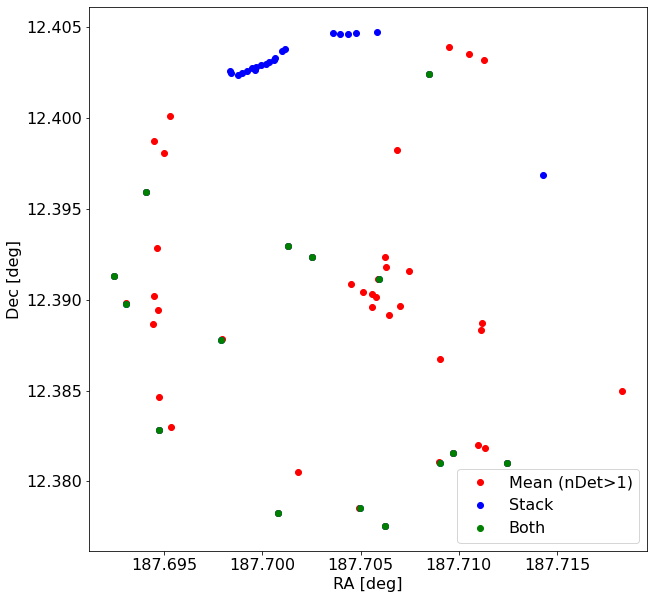

In [14]:
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,10))
pylab.plot(tab['raMean'], tab['decMean'], 'ro', label='Mean (nDet>1)')
pylab.plot(stab['raMean'], stab['decMean'], 'bo', label='Stack')
pylab.plot(jtab_both['raMean'], jtab_both['decMean'], 'go', label='Both')

pylab.xlabel('RA [deg]')
pylab.ylabel('Dec [deg]')
pylab.legend(loc='best')

Get light curve

In [15]:
objname = 'KQ UMa'
ra, dec = resolve(objname)
radius = 1.0/3600.0 # radius = 1 arcsec

results = ps1cone(ra,dec,radius,release='dr2',columns=columns,**constraints)
tab = ascii.read(results)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    tab[col].format = ".4f"
    tab[col][tab[col] == -999.0] = np.nan
tab

objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
190361393344112894,139.33445305334158,68.63505916169231,66,8,10,21,13,14,15.0402,14.5530,14.2109,14.2814,14.3041


Get detection information

In [16]:
def addfilter(dtab):
    """Add filter name as column in detection table by translating filterID
    
    This modifies the table in place.  If the 'filter' column already exists,
    the table is returned unchanged.
    """
    if 'filter' not in dtab.colnames:
        # the filterID value goes from 1 to 5 for grizy
        id2filter = np.array(list('grizy'))
        dtab['filter'] = id2filter[(dtab['filterID']-1).data]
    return dtab

objid = tab['objID'][0]
dconstraints = {'objID': objid}
dcolumns = ("""objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,
            psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3""").split(',')
# strip blanks and weed out blank and commented-out values
dcolumns = [x.strip() for x in dcolumns]
dcolumns = [x for x in dcolumns if x and not x.startswith('#')]

dresults = ps1search(table='detection',release='dr2',columns=dcolumns,**dconstraints)
dtab = addfilter(ascii.read(dresults))
dtab.sort('obsTime')
dtab

objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,filter
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str1
190361393344112894,115636667260000047,5,55257.3668569,139.33445713,68.63507615,0.005354930181056261,2.6245999833918177e-05,2.5283899307250977,2.4677300453186035,0.9989349842071533,0.005433760117739439,1.6695599697413854e-05,102760517,128,24119360,y
190361393344112894,115637788260000041,5,55257.3780646,139.33444929,68.63506405,0.005313179921358824,2.175470035581384e-05,1.8098100423812866,1.7773000001907349,0.999800980091095,0.005322880111634731,1.7123500583693385e-05,102760517,128,124815424,y
190361393344112894,118025265260000028,4,55281.2528285,139.33447243,68.63507592,0.005556920077651739,1.2427400179149117e-05,1.1078200340270996,0.9493029713630676,0.9975399971008301,0.005616980139166117,1.2113199773011729e-05,102760517,128,7374912,z
190361393344112894,118026233260000017,4,55281.2625151,139.3344753,68.63507505,0.006145799998193979,1.3183999726606999e-05,1.0866999626159668,0.9652569890022278,0.9555839896202087,0.006260519847273827,1.2802999663108494e-05,102760517,128,7374912,z
190361393344112894,142663796520000019,4,55527.6381469,139.33444657,68.63507265,0.005942150019109249,1.2578700079757255e-05,1.1702100038528442,1.1396000385284424,0.9973800182342529,0.0059954398311674595,1.2208300177007914e-05,102760517,128,7374912,z
190361393344112894,142665071520000011,4,55527.6508919,139.33444962,68.63506557,0.005690529942512512,1.2433300071279518e-05,1.1921099424362183,1.1337599754333496,0.9972649812698364,0.005855679977685213,1.2070199773006607e-05,102760517,128,7374912,z
190361393344112894,145454631520000040,5,55555.5464962,139.3344544,68.63505782,0.005188710056245327,2.3331000193138607e-05,1.792080044746399,1.558210015296936,0.9971089959144592,0.005270369816571474,1.846049963205587e-05,102760517,128,124815424,y
190361393344112894,145455366520000043,5,55555.5538486,139.33445034,68.63506318,0.0053047300316393375,2.412799949524924e-05,2.6756300926208496,2.5351500511169434,0.9975789785385132,0.005306419916450977,1.8608299797051586e-05,102760517,128,124815424,y
190361393344112894,153347716310000010,1,55634.477414,139.3345207,68.63503577,0.00826191995292902,1.1407400052121375e-05,1.881850004196167,1.7673399448394775,0.9929159879684448,0.008617050014436245,1.1423299838497769e-05,102760517,128,124782656,g


Plot light curves

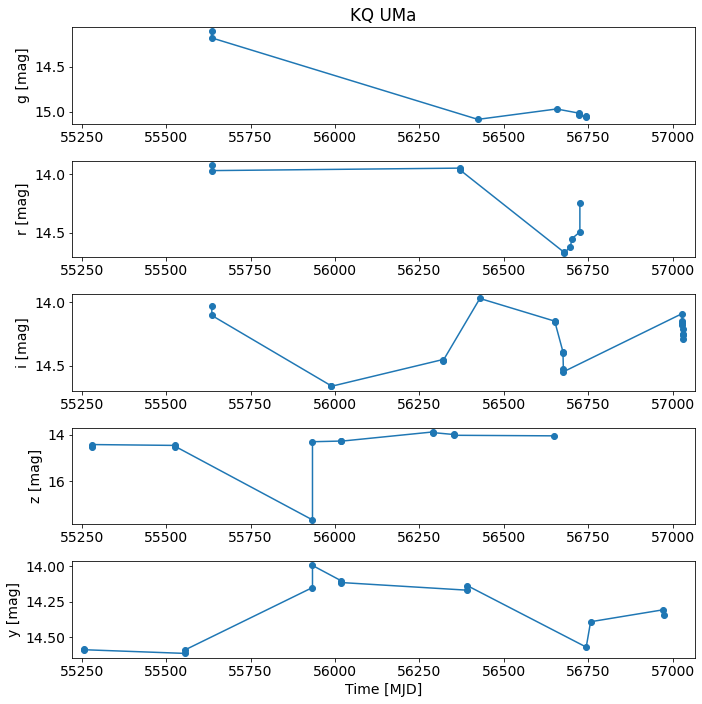

In [17]:
# convert flux in Jy to magnitudes
t = dtab['obsTime']
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)
    pylab.plot(t[w],mag[w],'-o')
    pylab.ylabel(filter+' [mag]')
    pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

Plot differences from the mean magnitudes in the initial search.



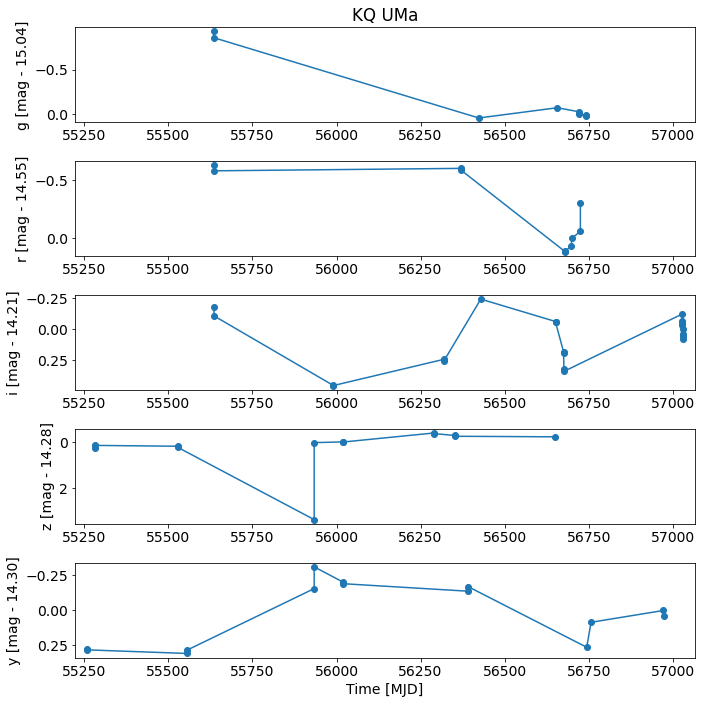

In [18]:
# convert flux in Jy to magnitudes
t = dtab['obsTime']
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)
    magmean = tab[filter+'MeanPSFMag'][0]
    pylab.plot(t[w],mag[w] - magmean,'-o')
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean))
    pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

---

## Examine images

In [19]:
%matplotlib inline
from __future__ import print_function
import numpy
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import pylab

In [20]:
def getimages(ra,dec,size=240,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

Sample JPEG images
This gets single-band grayscale and color JPEG images at the position of the Crab Nebula. The extracted region size is 1280 pixels = 320 arcsec.

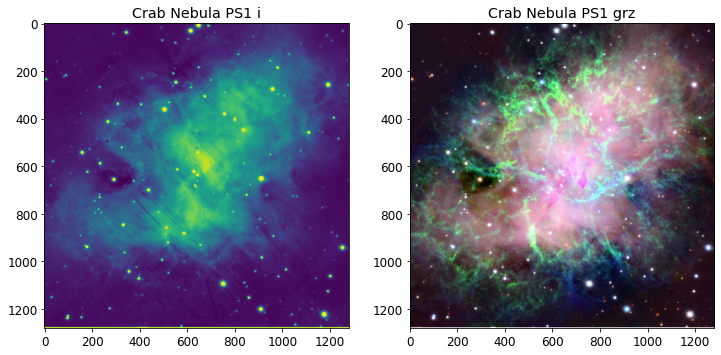

In [21]:
# Crab Nebula position
ra = 83.633210
dec = 22.014460
size = 1280

# grayscale image
gim = getgrayim(ra,dec,size=size,filter="i")
# color image
cim = getcolorim(ra,dec,size=size,filters="grz")

pylab.rcParams.update({'font.size':12})
pylab.figure(1,(12,6))
pylab.subplot(121)
pylab.imshow(gim,origin="upper")
pylab.title('Crab Nebula PS1 i')
pylab.subplot(122)
pylab.title('Crab Nebula PS1 grz')
pylab.imshow(cim,origin="upper")


Load and display a FITS image
Note that the  y -axis is flipped in the JPEG image compared with the original FITS image.

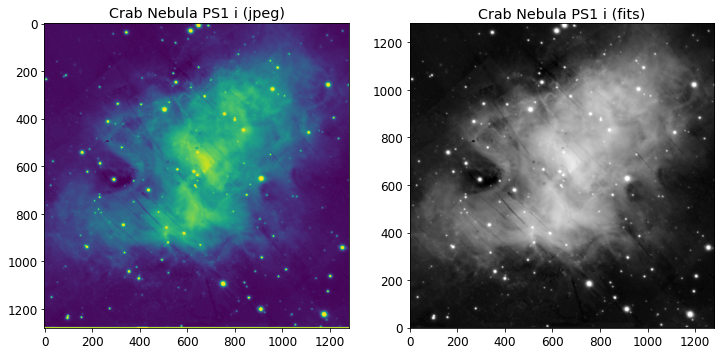

In [22]:
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch

fitsurl = geturl(ra, dec, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])
fim = fh[0].data
# replace NaN values with zero for display
fim[numpy.isnan(fim)] = 0.0
# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
bfim = transform(fim)

pylab.figure(1,(12,6))
pylab.subplot(121)
pylab.imshow(gim,origin="upper")
pylab.title('Crab Nebula PS1 i (jpeg)')

pylab.subplot(122)
pylab.title('Crab Nebula PS1 i (fits)')
pylab.imshow(bfim,cmap="gray",origin="lower")